In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import hdbscan
import seaborn as sns
sns.set_style("dark")

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option("display.max_rows",500)
pd.set_option("display.max_columns",100)
pd.set_option('max_colwidth', 100)

### Load the 2012 data:

In [3]:
data = pd.read_csv('data/college-scorecard-raw-data-030216/merged_2012_PP.csv', encoding='iso-8859-1',
                   na_values="PrivacySuppressed")


In [4]:
alldata = pd.DataFrame()
for yr in range(1996,2014):
    data = pd.read_csv('data/college-scorecard-raw-data-030216/merged_'+str(yr)+'_PP.csv', encoding='iso-8859-1',
                       na_values="PrivacySuppressed")
    data['year'] = yr
    alldata = pd.concat((alldata,data))
alldata.info()

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 124699 entries, 0 to 7803
Columns: 1730 entries, UNITID to year
dtypes: float64(1713), int64(7), object(10)
memory usage: 1.6+ GB


In [5]:
alldata.set_index('UNITID', inplace=True)
yearly = alldata.groupby("year")

In [6]:
filled = yearly.get_group(2013)
for yr in range(2012,1995,-1):
    df = yearly.get_group(yr)
    filled = filled.combine_first(df)
filled = filled[filled.index.isin(yearly.get_group(2013).index)]
filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7804 entries, 100654 to 48285707
Columns: 1729 entries, OPEID to year
dtypes: float64(1719), object(10)
memory usage: 103.0+ MB


In [7]:
bachelors = filled[filled.sch_deg == 3]
bachelors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 100654 to 47702003
Columns: 1729 entries, OPEID to year
dtypes: float64(1719), object(10)
memory usage: 33.8+ MB


Group variables by dev-category using the Data Dictionary.

In [8]:
df_dict = pd.read_csv('data/CollegeScorecardDataDictionary-09-08-2015.csv')
df_dict.columns

Index(['NAME OF DATA ELEMENT', 'dev-category', 'developer-friendly name',
       'API data type', 'VARIABLE NAME', 'VALUE', 'LABEL', 'SOURCE', 'NOTES'],
      dtype='object')

In [9]:
df_dict.set_index('VARIABLE NAME', inplace=True)
dcat = df_dict.groupby('dev-category')
dcat.groups.keys()

dict_keys(['repayment', 'root', 'earnings', 'completion', 'admissions', 'aid', 'cost', 'academics', 'school', 'student'])

In [10]:
ac_vars = dcat.groups['academics']
ac_dict = dcat.get_group('academics')
len(ac_dict)

228

### The data in the _academics_ category consists of two things:  Percentage of degrees awarded in a particular discipline area, and flags for whether or not an institution has a given degree:

In [11]:
ac_dict[['developer-friendly name', 'NAME OF DATA ELEMENT']]

,developer-friendly name,NAME OF DATA ELEMENT
VARIABLE NAME,,
PCIP01,program_percentage.agriculture,"Percentage of degrees awarded in Agriculture, Agriculture Operations, And Related Sciences."
PCIP03,program_percentage.resources,Percentage of degrees awarded in Natural Resources And Conservation.
PCIP04,program_percentage.architecture,Percentage of degrees awarded in Architecture And Related Services.
PCIP05,program_percentage.ethnic_cultural_gender,"Percentage of degrees awarded in Area, Ethnic, Cultural, Gender, And Group Studies."
PCIP09,program_percentage.communication,"Percentage of degrees awarded in Communication, Journalism, And Related Programs."
PCIP10,program_percentage.communications_technology,Percentage of degrees awarded in Communications Technologies/Technicians And Support Services.
PCIP11,program_percentage.computer,Percentage of degrees awarded in Computer And Information Sciences And Support Services.
PCIP12,program_percentage.personal_culinary,Percentage of degrees awarded in Personal And Culinary Services.
PCIP13,program_percentage.education,Percentage of degrees awarded in Education.


The repayment data is very similar to the reduced completion data. Repayment statistics are broken out for students who have entered repayment after having either:
- completed their degree course.
- withdrawn without completing.

These statistics are provided for students who are 1, 3, 5, and 7 years out of college, and are further broken down into similar demographic categories as the completion data, sans race, plus dependent status.

### Now let's examine what data is available:

In [12]:
academics = bachelors[["INSTNM", "sch_deg", "year"]+ac_vars]

In [13]:
academics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2560 entries, 100654 to 47702003
Columns: 231 entries, INSTNM to CIP54BACHL
dtypes: float64(230), object(1)
memory usage: 4.5+ MB


## Repayment data histogram by school:

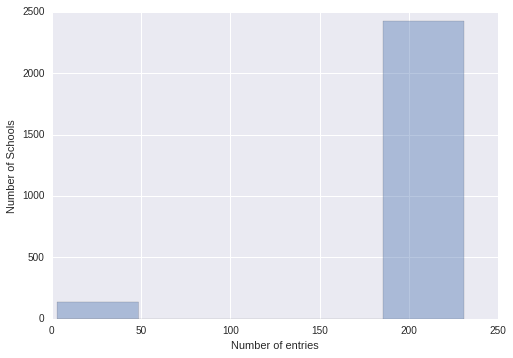

In [14]:
sns.set_style("darkgrid")
sns.distplot(academics.count(axis=1), bins=5, kde=False)
plt.xlabel("Number of entries")
plt.ylabel("Number of Schools")
plt.savefig("Academics_Data_histogram_all.png")

So, appears the majority of schools have nearly all the available data, while a few have nearly none.

### Repayment histogram by Variable

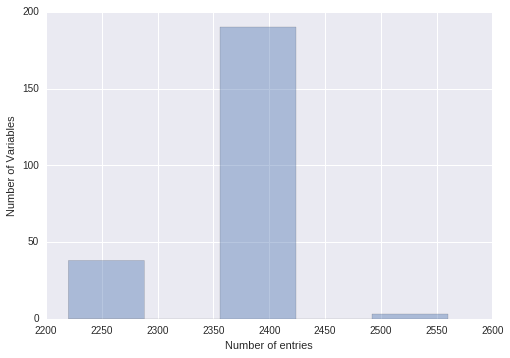

In [15]:
sns.distplot(academics.count(axis=0), bins=5, kde=False, rug=False)
plt.xlabel("Number of entries")
plt.ylabel("Number of Variables")

In [16]:
col_entry_counts = academics.count(axis=0)
col_entry_counts.sort_values()

PCIP43        2220
PCIP29        2220
PCIP31        2220
PCIP38        2220
PCIP39        2220
PCIP40        2220
PCIP41        2220
PCIP42        2220
PCIP44        2220
PCIP45        2220
PCIP46        2220
PCIP47        2220
PCIP48        2220
PCIP49        2220
PCIP50        2220
PCIP51        2220
PCIP52        2220
PCIP54        2220
PCIP27        2220
PCIP26        2220
PCIP30        2220
PCIP24        2220
PCIP01        2220
PCIP03        2220
PCIP04        2220
PCIP05        2220
PCIP25        2220
PCIP10        2220
PCIP11        2220
PCIP12        2220
PCIP09        2220
PCIP13        2220
PCIP14        2220
PCIP15        2220
PCIP16        2220
PCIP19        2220
PCIP22        2220
PCIP23        2220
CIP41CERT2    2423
CIP41CERT1    2423
CIP40BACHL    2423
CIP40CERT4    2423
CIP40CERT1    2423
CIP39BACHL    2423
CIP40CERT2    2423
CIP41ASSOC    2423
CIP40ASSOC    2423
CIP41CERT4    2423
CIP23BACHL    2423
CIP42CERT1    2423
CIP42CERT2    2423
CIP42ASSOC    2423
CIP42CERT4  

In [17]:
col_entry_counts.unique()

array([2560, 2220, 2423])

Three.  Three unique counts for 231 entries.  Not a whole lot of variation here...

# Summary:
1. There is very little variation in the academic data once you combine all available years and take just the bachelor's degree-granting institutions.  
    * I did however note that sch_deg=3 does not restrict the data to your stereotypical 4-year public or private university, e.g., schools like the American Film Institute Conservatory, the Academy of Chinese Culture and Health Sciences, the Frank Lloyd Wright School of Architecture, and the American Baptist Seminary of the West.

2. There are 228 variables in the academics data, which can be broken into two categories:
    * Percentage of degrees awarded in a particular discipline area.
    * Flags for whether or not an institution has a given degree.

#### I suggest we drop all the degree flags and just keep the `PCIP[01-54]` variables for the percentage of degrees.  This information should be useful in distinguishing things like engineering schools, seminaries, and architecture schools from 4-year institutions with a broader mission.  

#### AND, if we want to further cut down the number of variables, we can combine these 54 variables further into broader degree classifications as needed.